# West Nile Virus Revisited

## Import files

In [1]:
import kagglehub
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

!kaggle competitions download -c predict-west-nile-virus

import zipfile
import os

# Define the extraction folder
data_folder = "west_nile_data"

# Unzip all .zip files inside the folder
for file in os.listdir(data_folder):
    if file.endswith(".zip"):
        file_path = os.path.join(data_folder, file)
        with zipfile.ZipFile(file_path, "r") as zip_ref:
            zip_ref.extractall(data_folder)  # Extract to the same folder
        print(f"Extracted: {file}")


predict-west-nile-virus.zip: Skipping, found more recently modified local copy (use --force to force download)
Extracted: mapdata_copyright_openstreetmap_contributors.txt.zip
Extracted: sampleSubmission.csv.zip
Extracted: spray.csv.zip
Extracted: test.csv.zip
Extracted: train.csv.zip
Extracted: weather.csv.zip
Extracted: west_nile.zip


In [2]:
train = pd.read_csv(os.path.join(data_folder, "train.csv"))
test = pd.read_csv(os.path.join(data_folder, "test.csv"))
weather = pd.read_csv(os.path.join(data_folder, "weather.csv"))
spray = pd.read_csv(os.path.join(data_folder, "spray.csv"))


### Preprocessing 'Weather' Data


#### *Convert to correct types and remove columns with excessive NAs*

In [3]:

#Ensure 'Date' in correct form for ALL datasets
for i in train, test, weather, spray:
    i.Date = pd.to_datetime(i.Date)

#Remove those with excessive NA values
weather = weather.drop(columns=["Water1", "Depart","SnowFall","Depth"])    
weather.Date.dtype


#Convert those that should be numeric 
to_numericize = ['Tavg', 'Tmin', 'Tmax', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']

for col in to_numericize:
    weather[col] = pd.to_numeric(weather[col], errors='coerce') #coerce M letters to NA

#Check missing values ("M" string)

NA_w = pd.DataFrame(( (weather == 'M') | pd.isna(weather) ).sum(), columns=['number'])
NA_w['percent'] = (NA_w.number/len(weather)*100).round(1)
NA_w = NA_w.T
NA_w.style.map(lambda x: 'background-color: pink' if x != 0 else '', subset=pd.IndexSlice[:,:])


,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
number,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,4.000000,11.000000,11.000000,0.000000,0.000000,0.000000,320.000000,4.000000,9.000000,0.000000,0.000000,3.000000
percent,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.100000,0.400000,0.400000,0.000000,0.000000,0.000000,10.900000,0.100000,0.300000,0.000000,0.000000,0.100000


#### *Calculate sunlight hours per day using sunrise and sunset times*

In [4]:


#We have sunset and sunrise; we want hours of light
#Convert to minutes ()

def Minutes (HHMM):
    if HHMM == '-':
        return np.NaN
    else:
        hour = float(HHMM[:2])
        minute = float(HHMM[2:])
        return hour*60 + minute

SR = weather.Sunrise.apply(Minutes)
SS = weather.Sunset.apply(Minutes)

#calculate hours in day
weather['Sunlight'] = (SS - SR)/60



#### *Merge station 1 and station 2 by average where appropriate*
- Average wind direction using a special formula.
- Create a `CodeSum` variable made up of length 2 characters with information (e.g., `FG` = fog). Combine all unique features between stations.
  - Where one station has NA, take the value from the other.
  - Create column for each variable in CodeSum

In [5]:
#Our data is by station. We have no reason to keep both stations in data, as we don't know location. Thus we can combine.

s1 = weather.iloc[::2].copy()
s2 = weather.iloc[1::2].copy()

#Add values that are only given for S1
merged = pd.DataFrame({"Date": s1["Date"],"Sunrise": s1["Sunrise"],"Sunset": s1["Sunset"],"Sunlight": s1["Sunlight"]})

merged.reset_index(drop=True, inplace=True)

#Get average of our variables and add to merged

to_avg = ["Tmax", "Tmin", "Tavg", "DewPoint", "WetBulb", "Heat", "Cool", "PrecipTotal", "StnPressure", "SeaLevel","AvgSpeed"]

def avg_s(to_avg):
    result = {}
    for column in to_avg:
        result[column] = [
            a if np.isnan(b) else b if np.isnan(a) else (a + b) / 2  # Ensures that NA are replaced by a value if available
            for a, b in zip(s1[column], s2[column])
        ]
    return result


avg = pd.DataFrame(avg_s(to_avg))

merged = pd.concat([merged, avg], axis = 1)


#Average for ResultDir (direction of wind) requires seperate average calculation: 
rd = "ResultDir"
def avg_wind_direction(rd_column):
    result = []
    for a, b in zip(s1[rd_column], s2[rd_column]):
        if np.isnan(a):  # If one is NaN, take the other
            result.append(b)
        elif np.isnan(b):
            result.append(a)
        else:
            # Adjust for circular nature
            if abs(a - b) > 180:
                if a < b:
                    a += 360
                else:
                    b += 360
            avg = (a + b) / 2
            if avg >= 360:  # Ensure within 0-360 range
                avg -= 360
            result.append(avg)
    return result


avg_wind = pd.DataFrame({"ResultDir": avg_wind_direction(rd)})

merged = pd.concat([merged, avg_wind], axis = 1)


#### *CodeSum* - weather features
- combining all unique features between station 1 and 2
- hot encoding
  

In [6]:


s1c = s1.CodeSum.str.split(' ') #Split each code to obtain all codes
s1c = s1c.apply(lambda x: [i for i in x if i!='']) #Remove blank spaces in row lists

s2c = s2.CodeSum.str.split(' ') #Split each code to obtain all codes
s2c = s2c.apply(lambda x: [i for i in x if i!='']) #Remove blank spaces in row lists



# Use zip to iterate over s1c and s2c together, removing repeats    
new_cs = [list(set(a + b)) for a, b in zip(s1c, s2c)]

merged["CodeSum"] = new_cs

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
#Seperate for each temp variable from CodeSum
mlb = MultiLabelBinarizer()
code_arr = mlb.fit_transform(merged.CodeSum)

#Unique column per var
for i in range(mlb.classes_.shape[0]):
    merged[mlb.classes_[i]] = code_arr[:,i]

merged = merged.drop(columns = "CodeSum")

#### *Handle missing values*:
  - Drop variables with excessive NAs: `Water 1`, `Depart`, `Snowfall`, and `Depth`.
  - For other categories that still contain NAs after merging stations, can try imputation: `PrecipTotal`, `StnPressure`
  - We have most missing values for  `PrecipTotal` (4.3%) so double check distribution before and after imputation helps ensure it has worked well

In [8]:
#After dealing with averages, we can check  if we still have any NA:


NA_m = pd.DataFrame(((merged == 'M') | pd.isna(merged)).sum(), columns=['number'])
NA_m['percent'] = (NA_m.number / len(merged) * 100).round(1)
NA_m = NA_m.T
NA_m.style.map(lambda x: 'background-color: pink' if x != 0 else '', subset=pd.IndexSlice[:,:])

#We need to impute for PrecipTotal and StnPressure


,Date,Sunrise,Sunset,Sunlight,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,AvgSpeed,ResultDir,BCFG,BR,DZ,FG,FG+,FU,GR,HZ,MIFG,RA,SN,SQ,TS,TSRA,VCFG,VCTS
number,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,64.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
percent,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.300000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#To impute data need only numeric columns
imputed_data = merged.copy()
imputed_data["Date"] = pd.to_numeric(imputed_data["Date"]) #Date back to unix

#Impute data
imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=42) 
imputed_data = imputer.fit_transform(imputed_data)
imputed_data =pd.DataFrame(imputed_data, columns=merged.columns)



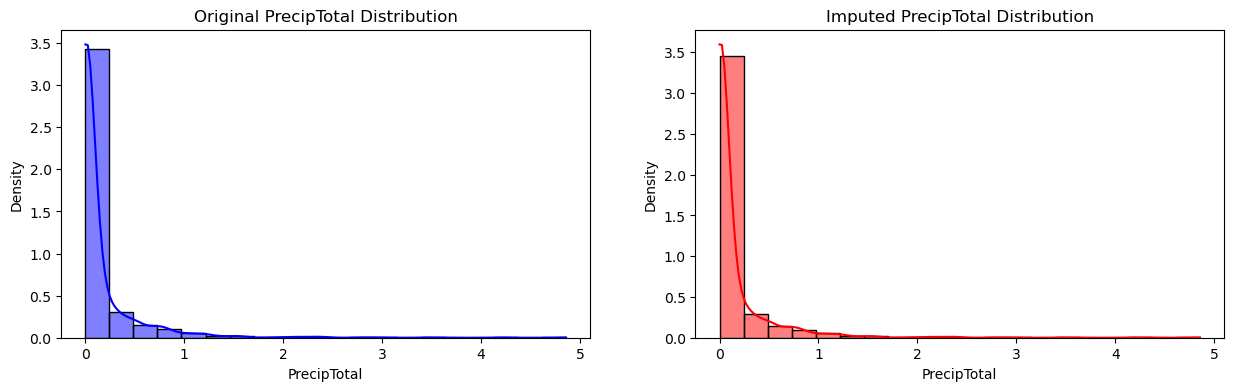

In [10]:
#Plot to make sure distribution of PrecipTotal hasn't changed


fig, axes = plt.subplots(1, 2, figsize=(15, 4))
# Plot for the original data 
sns.histplot(merged['PrecipTotal'], color='blue', kde=True, stat='density', bins=20, ax=axes[0])
axes[0].set_title('Original PrecipTotal Distribution')
axes[0].set_ylabel('Density')
# Plot for the imputed data 
sns.histplot(imputed_data['PrecipTotal'], color='red', kde=True, stat='density', bins=20, ax=axes[1])
axes[1].set_title('Imputed PrecipTotal Distribution')
axes[1].set_ylabel('Density')

plt.show()


## Initial Feature Selection

#### *View distributions of our variables*


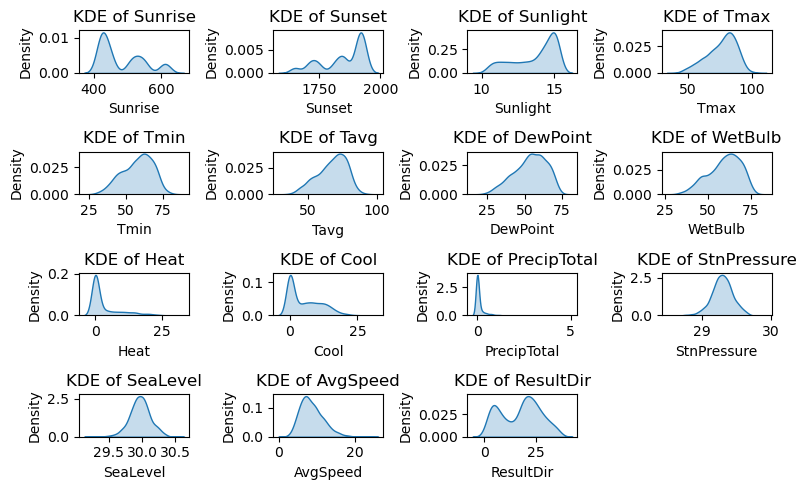

In [11]:
#

# Create subplots (adjust grid size dynamically if needed)
fig, axes = plt.subplots(4, 4, figsize=(8, 5))  # Adjust as needed
axes = axes.flatten()

# Loop over numerical columns and plot KDE
for i, col in enumerate(imputed_data.iloc[:,1:16]):
    sns.kdeplot(data=imputed_data, x=col, fill=True, ax=axes[i])
    axes[i].set_title(f'KDE of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()


#### *Correlation Matrix*
- Remove highly correlated features as an initial feature reduction
- It seems reasonable to get rid of max/min of temperature, and to include the average instead. Many of the other temperature features seem to be communicating the same data, so can remove them also.

<Axes: >

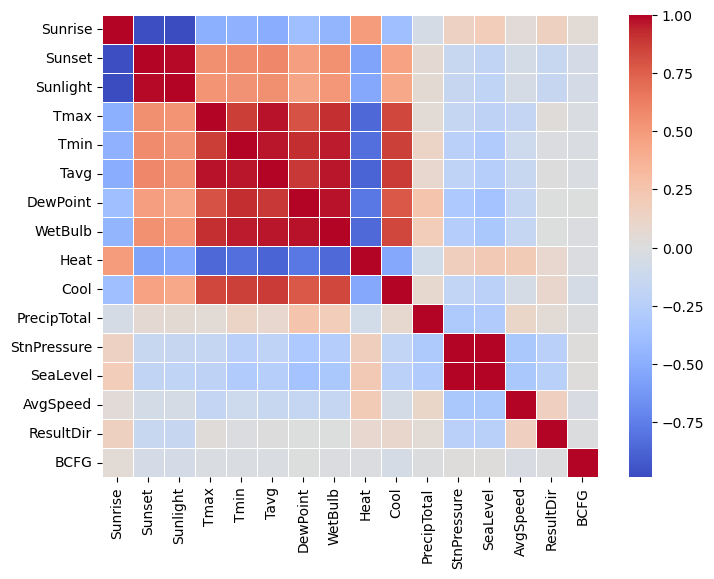

In [12]:
#Correlation matrix between numeric values

corr_matrix = imputed_data.iloc[:,1:17].corr(method="pearson") 

# Visualize heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", linewidths=0.5, annot_kws={"size": 8}, cmap="coolwarm")


<Axes: >

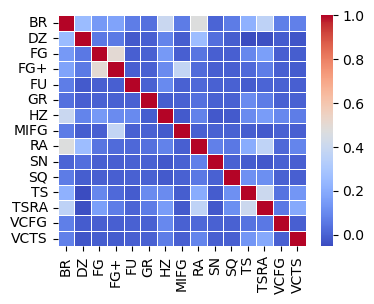

In [13]:
#Correlation matrix between CodeSum

corr_matrix = imputed_data.iloc[:,17:].corr(method="pearson") 

# Visualize heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", linewidths=0.5, annot_kws={"size": 8}, cmap="coolwarm")


In [14]:
#Remove highly correlated features

imputed_data = imputed_data.drop(columns= ["Tmin", "Tmax","WetBulb", "DewPoint", "Sunrise","Sunset", "Heat", "Cool"])

### Test/Train data wrangling


#### *Join train/test with the weather data*

In [15]:
train = pd.read_csv(os.path.join(data_folder, "train.csv"))
test = pd.read_csv(os.path.join(data_folder, "test.csv"))

#Deal with trap and species
#Use number of mosquitos per type of trap / per species
avgMT = train.groupby("Trap")["NumMosquitos"].mean()
avgMS = train.groupby("Species")["NumMosquitos"].mean()
train["avgMT"] = train["Trap"].map(avgMT)
train["avgMS"] = train["Species"].map(avgMS)

#Use values for test
test["avgMT"] = test["Trap"].map(avgMT)
test["avgMS"] = test["Species"].map(avgMS)

#For unknown trap/species, set as column average
test["avgMS"] = test["avgMS"].fillna(test["avgMS"].mean())
test["avgMT"] = test["avgMT"].fillna(test["avgMT"].mean())


#Remove address, and og trap/species/n mosquitos

train = train.drop(columns = ["Address", "Block", "Street", "AddressNumberAndStreet", "Trap", "Species", "NumMosquitos"])
test = test.drop(columns = ["Address", "Block", "Street", "AddressNumberAndStreet","Trap", "Species"])


#Join data

train.Date = pd.to_datetime(train.Date)
imputed_data.Date = pd.to_datetime(imputed_data.Date)

train_temp = pd.merge(train, imputed_data, on='Date', how='left')


test.Date = pd.to_datetime(test.Date)
imputed_data.Date = pd.to_datetime(imputed_data.Date)

test_temp = pd.merge(test, imputed_data, on='Date', how='left')




## *Fitting the model*
- As it is spatial data, we cannot make a linear assumption, as the residuals will likely be correlated.
- Given the size of the dataset, applying spatial techniques (like spatial autocorrelation or kriging) becomes computationally expensive and may not scale well
- Therefore, I used tree-based models for this data. I used random forests, and a gradient boosted tree method to fit the data.


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = train_temp.drop(columns = ["Date", "WnvPresent"])
y = train_temp["WnvPresent"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)


# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Predict probabilities
predict = rf.predict_proba(X_test)

# Calculate ROC AUC score
roc_auc = metrics.roc_auc_score(y_test, predict[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.7834


In [17]:
import xgboost as xgb


# XGBoost
xgb_model = xgb.XGBClassifier( eval_metric='logloss')  
xgb_model.fit(X_train, y_train)  
predict = xgb_model.predict_proba(X_test)  # predict probabilities

# Calculate AUC
roc_auc = metrics.roc_auc_score(y_test, predict[:, 1])  # AUC score for positive class
print(roc_auc)


0.8259289525460727


## Feature Selection (post-model)
- The XGboost has outperformed the random forests model, as expected. We can see which features are contributing most to our model, to make our model simpler and more interpretable.

In [18]:
feature_importance = xgb_model.feature_importances_

importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.T

,5,24,13,6,2,1,3,7,4,8,...,14,18,20,17,22,23,16,12,26,27
Feature,Sunlight,TS,BR,Tavg,AddressAccuracy,Longitude,avgMT,PrecipTotal,avgMS,StnPressure,...,DZ,GR,MIFG,FU,SN,SQ,FG+,BCFG,VCFG,VCTS
Importance,0.152309,0.095922,0.068762,0.067947,0.057815,0.055711,0.054413,0.053135,0.05125,0.050748,...,0.00376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
#Remove all with 0 importance

X = train_temp.drop(columns = ["Date", "WnvPresent"])
no_importance = importance_df[importance_df["Importance"] == 0]["Feature"]
X = X.drop(columns = no_importance)




print(f"Removed = {no_importance.values}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)


# Scale categories


# XGBoost
xgb_model = xgb.XGBClassifier( eval_metric='logloss')  # Initialize XGBoost model
xgb_model.fit(X_train, y_train)  # Fit the model
predict = xgb_model.predict_proba(X_test)  # Predict probabilities

roc_auc = metrics.roc_auc_score(y_test, predict[:, 1])  # Calculate AUC score for positive class
print(roc_auc)


Removed = ['GR' 'MIFG' 'FU' 'SN' 'SQ' 'FG+' 'BCFG' 'VCFG' 'VCTS']
0.8242397253073135


## Validation

#### *Confusion Matrix + metrics*
- Split the data into train/test

Accuracy: 0.5390
Specificity: 0.5186
Sensitivity: 0.8994
PPV: 0.0957


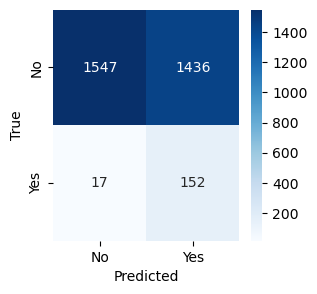

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np

# Choose your desired probability threshold (e.g., 0.5)
p_value = 0.002

# Predict probabilities
predict_proba = xgb_model.predict_proba(X_test)
# If the probability for class 1 is greater than p_value, predict 1; otherwise, predict 0
predict_labels = (predict_proba[:, 1] > p_value).astype(int)


# Generate the confusion matrix
cm = confusion_matrix(y_test, predict_labels)

TP = cm[1, 1]
FP = cm[0, 1]
PPV = TP / (TP + FP) 

# Print the metrics
print(f"Accuracy: {accuracy_score(y_test, predict_labels):.4f}")
print(f"Specificity: {cm[0,0] / (cm[0,0] + cm[0,1]):.4f}")

print(f"Sensitivity: {recall_score(y_test, predict_labels):.4f}")
print(f"PPV: {precision_score(y_test, predict_labels):.4f}")


# Plot the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


#### *ROC curve*

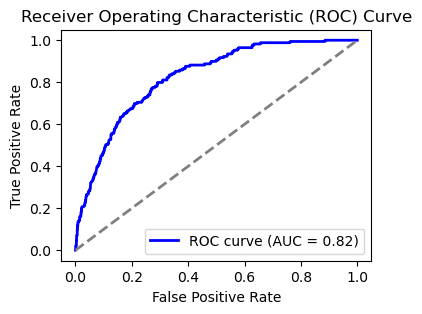

In [21]:
from sklearn.metrics import roc_curve, auc

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, predict_proba[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### Suggestions 
- The data is noisy and has an unequal distribution between the positive (virus present) and negative (no virus) classes.
- By changing the probability threshold, we can improve sensitivity. Even though specificity drops to 0.5,  this still significantly reduces the number of points to consider spraying.
- Additionally, mosquito spraying benefits to civillians even when moquitos do not have the virus. Thus, efforts are not wasted. 
  
- To see how this might look, we predicted data from 2011 from our training dataset. From the 'spray' data, we know there were 14,835 mosquito spraying efforts in 2011. Using our model, we could have reduced this to 856 time-location points while still capturing 92% of points where virus-positive mosquitoes were detected. 10% of the selected time-locations actually contained virus-positive mosquitoes.

- Applying this to the test set, we can make some suggestions for the future

In [22]:
#2011 from training data
train_2011 = train_temp[train_temp["Date"].dt.year == 2011]
target = train_2011["WnvPresent"]
train_2011 = train_2011[X.columns]

#Predict with model
tpp = xgb_model.predict_proba(train_2011)
tppp = (tpp[:, 1] > p_value).astype(int)

#Count n predicted to have virus
Pvirus2 = np.sum(tppp)
Pnvirus2 = len(tppp) - np.sum(tppp)  # Counts 0s
print(f"In 2011 of the training set, we predict {Pvirus2} timelocations will have the virus, while {Pnvirus2} will not.")

#Real metrics
cm = confusion_matrix(target, tppp)

TP = cm[1, 1]
FP = cm[0, 1]
PPV = TP / (TP + FP) 

# Print the metrics
print(f"Accuracy: {accuracy_score(y_test, predict_labels):.4f}")
print(f"Specificity: {cm[0,0] / (cm[0,0] + cm[0,1]):.4f}")

print(f"Sensitivity: {recall_score(y_test, predict_labels):.4f}")
print(f"PPV: {precision_score(y_test, predict_labels):.4f}")



In 2011 of the training set, we predict 853 timelocations will have the virus, while 1201 will not.
Accuracy: 0.5390
Specificity: 0.6009
Sensitivity: 0.8994
PPV: 0.0957


In [23]:

# Prediction of test_temp
t = test_temp.copy()
t = t.drop(columns=['Id', 'Date'])
t = t.drop(columns=no_importance)

# recall at different thresholds
def precall(p):
    return recall_score(y_test, (xgb_model.predict_proba(X_test)[:, 1] > p).astype(int))
# n locations at different thresholds
def tospray(p):
    return (xgb_model.predict_proba(t)[:, 1] > p).sum()  
def ppd(p):
    return precision_score(y_test, (xgb_model.predict_proba(X_test)[:, 1] > p).astype(int))
# DataFrame with thresholds
data = {"Threshold": [0.001, 0.0025, 0.005, 0.01, 0.05, 0.1]}
df = pd.DataFrame(data)
df["Percent(%) of virus-positive areas captured"] = df["Threshold"].apply(precall)
df["Total time-locations to spray"] = df["Threshold"].apply(tospray)
df["PPD"] = df["Threshold"].apply(ppd)
# Print DataFrame
df


,Threshold,Percent(%) of virus-positive areas captured,Total time-locations to spray,PPD
0,0.0010,0.934911,32465,0.088120
1,0.0025,0.887574,19588,0.098945
2,0.0050,0.863905,12637,0.112916
3,0.0100,0.810651,8074,0.127679
4,0.0500,0.644970,2780,0.175523
5,0.1000,0.526627,1570,0.197339
